In [1]:
import pandas as pd
import numpy as np

import _pickle as pickle
from collections import Counter
from pprint import pprint
from datetime import datetime
import shutil
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR
RESULTS_DIR = ROOT_DIR + "results/"

# Train - 1168
# Validation - 292 videos 
# Test - 252 videos 

TRAINING_DATA_DIR = DATA_DIR + 'video_training_data/' # Directory storing videos as separate files
TRAINING_DATA_COUNT = 1168

TRAINING_DATA = DATA_DIR + "video_training_data.p" # each read gives labelled video [(segment, label), segment_2, ...]
VALIDATION_DATA = DATA_DIR + "video_validation_data.p" 
TEST_DATA = DATA_DIR + "video_testing_data.p" # each read gives video [(segment), segment_2, ...]

## Load data from file

In [3]:
def get_next_video_data(f):    
    is_end_reached = False
    
    try:
        video = pickle.load(f) # [(segment, label), ...]
    except (EOFError):
        is_end_reached = True
        return [], is_end_reached
    
    return video, is_end_reached

In [4]:
def get_video_data(idx): 
    train_video_f = open(TRAINING_DATA_DIR + str(idx) + '.p', 'rb') 
    video = pickle.load(train_video_f) # [(segment, label), ...]
    train_video_f.close()
    
    return video

## Model Architecture

**Temporal Model (RNN, LSTM, GRU):**
- [x] Add dropout
- [ ] Add stacking / another lstm
- [ ] No temporal pooling
- [x] Max pooling
- [x] Avg pooling
- [x] [Concat pooling](https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130)
- [ ] CS4248 12-rnn slide 32: Use pooled hidden states (segment level) in another RNN, and predict for each resultatnt hidden state. 



- [ ] Use LSTM for segment-wise hidden states
- [ ] Use weighted average pooling

**Try out models:**
- [ ] RNN
- [x] LSTM
- [x] GRU
- [x] [QRNN](https://github.com/salesforce/pytorch-qrnn)
- [ ] Nested LSTM
- [ ] TCN


[LSTM vs GRU](https://blog.floydhub.com/gru-with-pytorch/) explanation and comparison article


**Training:**
- [x] Shuffle data
- [ ] Xavier normal initialisation
- [ ] Xavier uniform initialisation


Don't use the SIL frames

In [5]:
class ClassPredictor(nn.Module):
    def __init__(self, input_size, num_classes, drop_prob):
        super(ClassPredictor, self).__init__()
        
        self.input_dout = nn.Dropout(drop_prob) 
        
        hidden_1 = 120
        hidden_2 = 80        
        
        # https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.l_relu1 = nn.LeakyReLU()
        self.dout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.l_relu2 = nn.LeakyReLU()
        self.dout2 = nn.Dropout(0.1)

        self.out = nn.Linear(hidden_2, num_classes)
        
        nn.init.orthogonal_(self.fc1.weight).requires_grad_().cuda()
        nn.init.orthogonal_(self.fc2.weight).requires_grad_().cuda()
        nn.init.orthogonal_(self.out.weight).requires_grad_().cuda()


    def forward(self, x):
        ## x: (input_size)

        # Manually use dropout for the Segment BiGRU output
        x = self.input_dout(x)
        
        a1 = self.fc1(x)
        h1 = self.l_relu1(a1)
        dout1 = self.dout1(h1)

        a2 = self.fc2(dout1)
        h2 = self.l_relu2(a2)
        dout2 = self.dout2(h2)

        # y: (num_classes)
#         y = self.out(h2)
        y = self.out(dout2)

        return y

In [6]:
class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, segment_hidden_size, num_layers, num_classes, drop_prob):
        super(BiGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        ## https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
        self.bigru =nn.GRU(input_size, hidden_size, num_layers, bidirectional=True, 
                            batch_first=True, bias=True) #, dropout=drop_prob) # dropout is only for stacked layers
        
        self.segment_hidden_size = segment_hidden_size #int(hidden_size / 2)
        self.segment_bigru =nn.GRU(hidden_size * 2 * 2, segment_hidden_size, num_layers, bidirectional=True, 
                            batch_first=True, bias=True)
        
        ## DNN for class prediction
        self.fc = ClassPredictor(self.segment_hidden_size * 2, num_classes, drop_prob)
 

    ## https://pytorch.org/docs/stable/nn.init.html
    def init_hidden_state(self, batch_size):
        #h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)

        h0 = torch.empty(self.num_layers * 2, batch_size, self.hidden_size).double()
        h0 = nn.init.orthogonal_(h0)
        h0 = h0.requires_grad_().cuda()
        
        return h0
 

    def init_segment_hidden_state(self, batch_size):
        #h0 = torch.zeros(self.num_layers * 2, batch_size, self.segment_hidden_size)

        sh0 = torch.empty(self.num_layers * 2, batch_size, self.segment_hidden_size).double()
        sh0 = nn.init.orthogonal_(sh0)
        sh0 = sh0.requires_grad_().cuda()
        
        return sh0
    
    
    def forward(self, x, segment_indices):
        ## x: (batch_size, seq_len, feature_len)
        ## segment_indices: (num_segments, 2)
        
        batch_size = x.size(0)

        ## Set initial states
        ## h0: (num_layers * num_directions, batch_size, hidden_size)
        h0 = self.init_hidden_state(batch_size)
        
        ## Forward propagate
        ## out: tensor of shape (batch_size, seq_length, hidden_size * 2)
        out, _ = self.bigru(x, h0)  
        
        ## Use hidden states of each segment to predict their labels
        concat_input = []
        for (start, end) in segment_indices:
            hidden_states = out[:, start:end, :]
            
            ## Compute the hidden state by doing temporal pooling over all time steps
            ## pool_out: (hidden_size * 2)
            max_pool_out = F.adaptive_max_pool1d(hidden_states.permute(0,2,1), 1).squeeze()
            avg_pool_out = torch.mean(hidden_states, dim=1).squeeze()

            ## concat_pool_out: (hidden_size * 2 * 2)
            concat_pool_out = torch.cat([max_pool_out, avg_pool_out])

            concat_input.append(concat_pool_out)

        ## concat_input: (1, num_segments, hidden_size * 2 * 2)
        concat_input = torch.stack(concat_input).unsqueeze(dim=0)
        
        
        ## sh0: (num_layers * num_directions, batch_size, segment_hidden_size)
        sh0 = self.init_segment_hidden_state(batch_size)
        
        ## s_out: tensor of shape (batch_size, num_segments, segment_hidden_size * 2)
        s_out, _ = self.segment_bigru(concat_input, sh0) 
    

        num_segments = s_out.shape[1]
       
        segment_outputs = []
        for i in range(num_segments):
            ## inp: (segment_hidden_size * 2)
            inp = s_out[:,i,:].squeeze()

            ## output: (num_classes)
            output = self.fc(inp)

            segment_outputs.append(output)
        
        ## segment_outputs: (num_segments, num_classes)
        segment_outputs = torch.stack(segment_outputs)
        
        return segment_outputs

## Train model on entire videos (sequence of segments which are sequence of frames)

In [7]:
def transform_to_inputs(video):
    segments = [] # segments (list of frames) in the video
    labels = [] # labels of each segment
    segment_indices = []
    offset = 0
    for segment_num in range(len(video)):
        segments.append(video[segment_num][0])
        labels.append(video[segment_num][1])
        segment_indices.append((offset, offset + video[segment_num][0].shape[0]))

        offset += video[segment_num][0].shape[0]
        
    # Load frames as tensors with gradient accumulation abilities
    input_frames = torch.cat(segments, 0).unsqueeze(0).requires_grad_().cuda() # unsqueeze to add batch dim
    labels = torch.Tensor(labels).long().cuda()
    segment_indices = torch.IntTensor(segment_indices).cuda()
    
    return input_frames, labels, segment_indices

In [8]:
def save_checkpoint(state, is_best, folder):
    filename = folder + 'model_checkpoint.pth'
    torch.save(state, filename)
    
    if is_best:
        shutil.copyfile(filename, folder + 'model_best.pth')

def train_model(model, num_epochs, should_shuffle, train_data_file=TRAINING_DATA, validation_data_file=VALIDATION_DATA):
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    best = float("inf")
    
    for epoch in range(num_epochs):
        start = time.time()
        print('======================================================================')
        print('Epoch: {}'.format(epoch))
        
        video_idxs = np.arange(TRAINING_DATA_COUNT)
        if should_shuffle:
            np.random.shuffle(video_idxs)
        
        correct = 0
        total = 0

        video_num = 0
        epoch_training_losses = []

        model.train()
        for idx in video_idxs:
            video = get_video_data(idx)
            
            inputs, labels, segment_indices = transform_to_inputs(video)

            outputs = model(inputs, segment_indices)
            loss = loss_criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_training_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            video_num += 1
            if video_num % 250 == 0:
                print('      Video: {}/1168  Loss: {}'.format(video_num, np.mean(epoch_training_losses))) 

        train_accuracy = 100 * correct / total
        
        
        # Evaluate on validation set
        try:
            val_f.close()    
        except(NameError):
            pass  
            
        val_f = open(validation_data_file, 'rb')
        model.eval()
        
        correct = 0
        total = 0
        is_file_end = False

        epoch_validation_losses = []
        
        with torch.no_grad(): # Saves memory and faster computation
            while not is_file_end:
                video, is_file_end = get_next_video_data(val_f)
                if is_file_end:
                    break

                inputs, labels, segment_indices = transform_to_inputs(video)

                outputs = model(inputs, segment_indices)
                loss = loss_criterion(outputs, labels)
                epoch_validation_losses.append(loss.item())

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_f.close()
        
        val_accuracy = 100 * correct / total
        
        
        # Print loss and accuracy
        training_losses.append(np.mean(epoch_training_losses))
        validation_losses.append(np.mean(epoch_validation_losses))
        training_accuracies.append(train_accuracy)
        validation_accuracies.append(val_accuracy)
        

        scheduler.step(validation_losses[-1])

        end = time.time()

        print('   Training Loss: {:.5f}  Validation Loss: {:.5f}'.format(training_losses[-1], validation_losses[-1]))
        print('   Training Accuracy: {:.3f}%   Validation Accuracy: {:.3f}%'.format(train_accuracy, val_accuracy))        
        
        is_best = validation_losses[-1] < best
        best = min(validation_losses[-1], best)
        save_checkpoint({
            'next_epoch_idx': epoch + 1,
            'state_dict': model.state_dict(),
            'val_loss': validation_losses[-1],
            'optimizer' : optimizer.state_dict(),
        }, is_best, RESULTS_DIR + model_time + '/')

        print('Best Validation Loss: {:.5f}'.format(best))
        print('Epoch took {:.2f} minutes'.format((end - start) / 60))

    return training_losses, validation_losses, training_accuracies, validation_accuracies

In [9]:
model_time = str(datetime.now().strftime("%Y-%m-%d___%H-%M-%S"))
os.mkdir(RESULTS_DIR + model_time)
print(model_time)
shutil.copyfile('Bidirectional_video.ipynb', RESULTS_DIR + model_time + '/' + model_time + '_Bidirectional_video.ipynb')

## Model Architecture
input_dim = 400  # dimension of an i3D video frame
hidden_dim = 160 # dimension of hidden state
segment_hidden_dim = 100 # dimension of the hidden state of the segment RNN
layer_dim = 1    # number of stacked layers
output_dim = 48  # number of sub-action labels

drop_prob = 0.2 # dropout prob of final RNN output

model = BiGRU(input_dim, hidden_dim, segment_hidden_dim, layer_dim, output_dim, drop_prob)

model = model.double().cuda() # transform the model parameters to double precision


## Loss function
loss_criterion = nn.CrossEntropyLoss()


## Optimizer
learning_rate = 0.01
weight_decay = 0.00005
momentum = 0.9

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 


## Learning Rate Scheduler
patience = 2
decrease_factor = 0.7
min_learning_rate = 0.00005
scheduler = ReduceLROnPlateau(optimizer, mode='min', 
                              patience=patience, min_lr=min_learning_rate, factor=decrease_factor,
                              verbose=True)


num_epochs = 15
should_shuffle = True 

training_start_time = time.time()
training_losses, validation_losses, training_accuracies, validation_accuracies = train_model(model, num_epochs, should_shuffle)
training_end_time = time.time()

print('-----------------------------------------------------')
print('Finished training', num_epochs, 'epochs in {:.2f} minutes'.format((training_end_time - training_start_time) / 60))

path = RESULTS_DIR + model_time + "/bidirectional_video_model.pth"
torch.save(model.state_dict(), path)
print("\nSaved trained model to", path)

2020-04-14___15-50-35
Epoch: 0
      Video: 250/1168  Loss: 3.637035280035846
      Video: 500/1168  Loss: 3.6152524883973474
      Video: 750/1168  Loss: 3.5503031289258167
      Video: 1000/1168  Loss: 3.45779129183664
   Training Loss: 3.39534  Validation Loss: 2.83438
   Training Accuracy: 9.599%   Validation Accuracy: 17.137%
Best Validation Loss: 2.83438
Epoch took 13.53 minutes
Epoch: 1
      Video: 250/1168  Loss: 2.8051705006638024
      Video: 500/1168  Loss: 2.707403622738514
      Video: 750/1168  Loss: 2.668417559461843
      Video: 1000/1168  Loss: 2.623478008400973
   Training Loss: 2.58983  Validation Loss: 2.19114
   Training Accuracy: 21.902%   Validation Accuracy: 31.664%
Best Validation Loss: 2.19114
Epoch took 14.10 minutes
Epoch: 2
      Video: 250/1168  Loss: 2.3564462834933075
      Video: 500/1168  Loss: 2.32196475750409
      Video: 750/1168  Loss: 2.2518179723416805
      Video: 1000/1168  Loss: 2.2191390545822878
   Training Loss: 2.18523  Validation Loss: 1

In [ ]:
# # new_learning_rate = 0.002

# # for param_group in optimizer.param_groups:
# #     param_group['lr'] = new_learning_rate


# num_epochs = 5

# training_start_time = time.time()
# t_losses, v_losses, t_accuracies, v_accuracies = train_model(model, num_epochs, should_shuffle)
# training_end_time = time.time()

# training_losses.extend(t_losses)
# validation_losses.extend(v_losses)
# training_accuracies.extend(t_accuracies)
# validation_accuracies.extend(v_accuracies)

# print('-----------------------------------------------------')
# print('Finished training', num_epochs, 'epochs in {:.2f} minutes'.format((training_end_time - training_start_time) / 60))

# path = RESULTS_DIR + model_time + "/bidirectional_video_model-25.pth"
# torch.save(model.state_dict(), path)
# print("\nSaved trained model to", path)

In [11]:
print(model)

BiGRU(
  (bigru): GRU(400, 160, batch_first=True, bidirectional=True)
  (segment_bigru): GRU(640, 100, batch_first=True, bidirectional=True)
  (fc): ClassPredictor(
    (input_dout): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=200, out_features=120, bias=True)
    (l_relu1): LeakyReLU(negative_slope=0.01)
    (dout1): Dropout(p=0.3, inplace=False)
    (fc2): Linear(in_features=120, out_features=80, bias=True)
    (l_relu2): LeakyReLU(negative_slope=0.01)
    (dout2): Dropout(p=0.1, inplace=False)
    (out): Linear(in_features=80, out_features=48, bias=True)
  )
)


In [ ]:
torch.cuda.empty_cache()

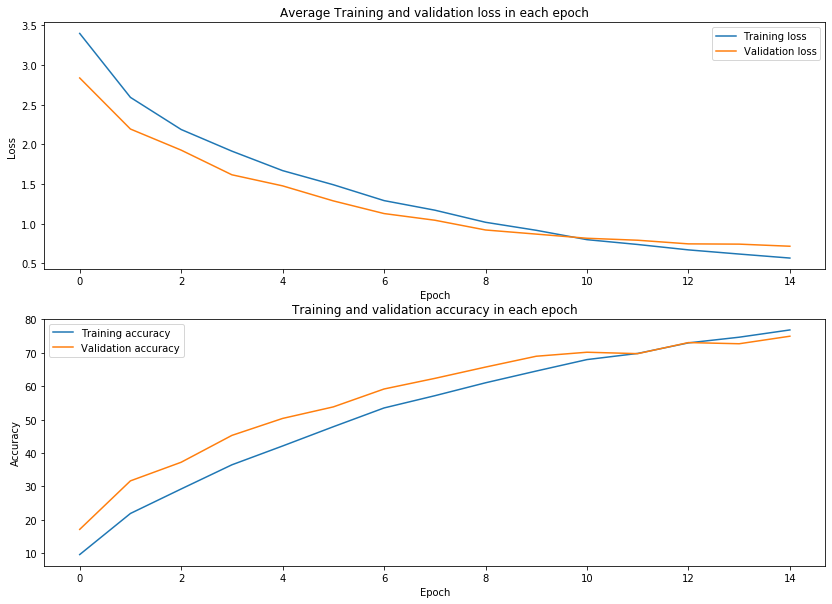

In [10]:
plt.figure(figsize=(14,10))

# Plot training and validation losses
plt.subplot(2, 1, 1)
plt.title("Average Training and validation loss in each epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend(["Training loss","Validation loss"])

# Plot training and validation accuracies
plt.subplot(2, 1, 2)
plt.title("Training and validation accuracy in each epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(training_accuracies)
plt.plot(validation_accuracies)
plt.legend(["Training accuracy","Validation accuracy"])

In [ ]:
# # Load saved checkpoint OR best model
# # checkpoint_path = RESULTS_DIR + "2020-04-05_20-52-22" + "/model_checkpoint.pth"
# checkpoint_path = RESULTS_DIR + "2020-04-14___10-57-16" + "/model_best.pth"

# checkpoint = torch.load(checkpoint_path)

# next_epoch_idx = checkpoint['next_epoch_idx']
# val_loss = checkpoint['val_loss']
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])

# print("=> loaded checkpoint '{}' (next_epoch_idx {})".format(checkpoint_path, next_epoch_idx))

# # # Load saved final model
# # path = RESULTS_DIR + "2020-04-08___10-06-06" + "/bidirectional_video_model-30.pth"
# # model.load_state_dict(torch.load(path))

# Evaluate model on validation set

In [12]:
model.eval()

try:
    val_f.close()    
except(NameError):
    ;   
val_f = open(VALIDATION_DATA, 'rb')

y = {'Actual': [], 'Predicted': []}

with torch.no_grad(): # Saves memory and faster computation
    is_file_end = False
    while not is_file_end:
        video, is_file_end = get_next_video_data(val_f)
        if is_file_end:
            break

        inputs, labels, segment_indices = transform_to_inputs(video)

        outputs = model(inputs, segment_indices)

        _, predicted = torch.max(outputs.data, 1)

        y['Actual'].extend(labels.tolist())
        y['Predicted'].extend(predicted.tolist())
    
y_df = pd.DataFrame(y)
path = RESULTS_DIR + model_time + "/val_results-15.csv" # -best
y_df.to_csv(path, encoding='utf-8', index=False)

print('Done predicting on validation set. Saved to', path)

Done predicting on validation set. Saved to ../results/2020-04-14___15-50-35/val_results-15.csv


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

print('\nMacro f1 Score= %.4f' % f1_score(y['Actual'], y['Predicted'], average="macro"))
print('Macro Precision= %.4f' % precision_score(y['Actual'], y['Predicted'], zero_division=0, average="macro"))
print('Macro Recall= %.4f' % recall_score(y['Actual'], y['Predicted'], average="macro")) 

print('\nMicro f1 Score= %.4f' % f1_score(y['Actual'], y['Predicted'], average="micro"))
print('Micro Precision= %.4f' % precision_score(y['Actual'], y['Predicted'], zero_division=0, average="micro"))
print('Micro Recall= %.4f' % recall_score(y['Actual'], y['Predicted'], average="micro")) 

print('\nAccuracy: %.4f' % accuracy_score(y['Actual'], y['Predicted']))

# Computes the average AUC of all possible pairwise combinations of classes. 
# Insensitive to class imbalance when average == 'macro'.
# print(roc_auc_score(y['Actual'], y['Predicted'], multi_class='ovo', average='macro')) 


Macro f1 Score= 0.6146
Macro Precision= 0.6594
Macro Recall= 0.6156

Micro f1 Score= 0.7525
Micro Precision= 0.7525
Micro Recall= 0.7525

Accuracy: 0.7525


In [14]:
# https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

from sklearn import metrics
print(metrics.classification_report(y['Actual'], y['Predicted']))

              precision    recall  f1-score   support

           1       0.91      0.81      0.85        36
           2       0.77      0.93      0.84       113
           3       0.62      0.45      0.53        11
           4       0.50      0.50      0.50        30
           5       0.79      0.92      0.85        24
           6       0.60      0.96      0.74        26
           7       0.67      0.33      0.44         6
           8       0.50      0.33      0.40         3
           9       0.00      0.00      0.00         2
          10       0.50      0.52      0.51        25
          11       0.68      0.83      0.74        88
          12       0.74      0.67      0.71        52
          13       0.89      0.76      0.82        33
          14       0.89      0.75      0.81        73
          15       0.88      0.87      0.88        53
          16       0.00      0.00      0.00         5
          17       0.68      0.78      0.73        41
          18       0.14    

C:\Users\amrut\.conda\envs\fyp\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


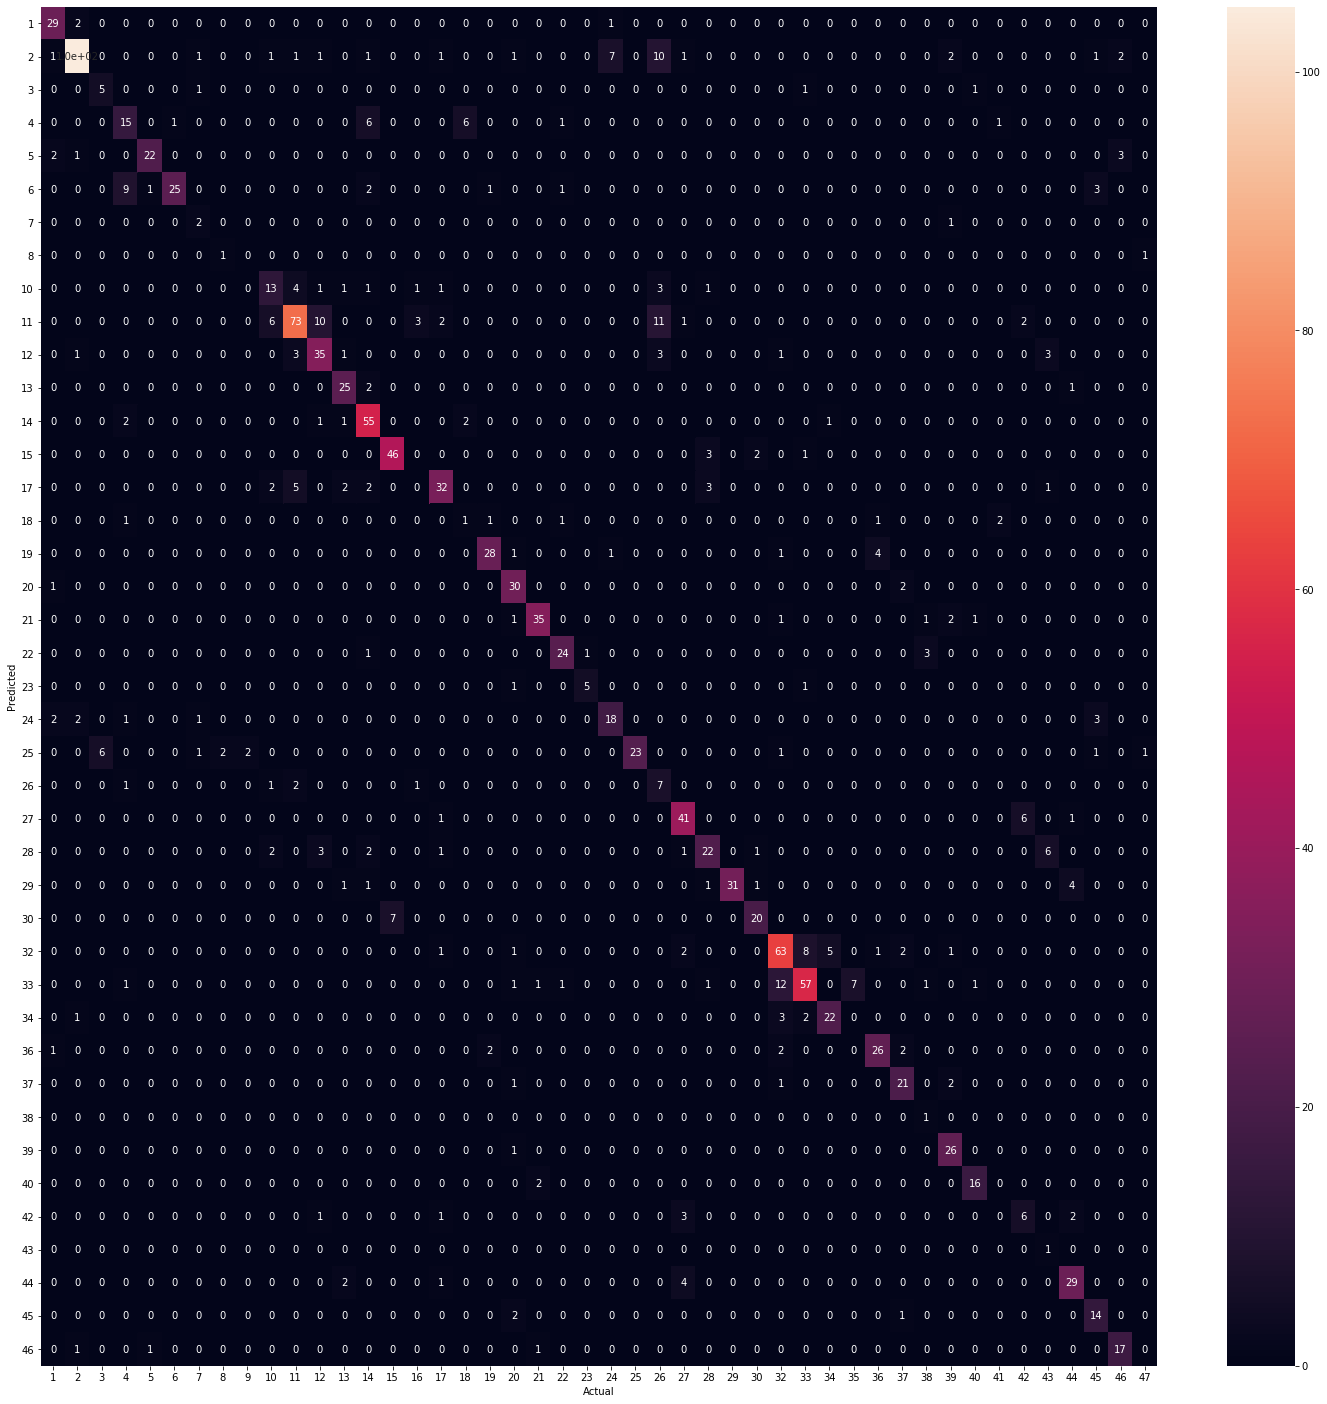

In [15]:
# Diagonal is correct predictions
df = pd.DataFrame({ 
    'Actual': y['Actual'], 
    'Predicted': y['Predicted'],
})

contingency_df = pd.crosstab(df['Predicted'], df['Actual'])
# display(contingency_df)

fig = plt.figure(figsize=(25,25))

g = sns.heatmap(contingency_df, annot=True)
g.set_yticklabels(g.get_yticklabels(), rotation = 0);

# Generate test data predictions for submission

In [16]:
NUM_TEST_SEGMENTS = 1284

model.eval()

try:
    test_f.close()    
except(NameError):
    pass   
test_f = open(TEST_DATA, 'rb')

y_pred = {'Id': np.arange(NUM_TEST_SEGMENTS), 'Category': []}

def transform_to_test_inputs(video):
    segments = [] # segments (list of frames) in the video
    segment_indices = []
    offset = 0
    for segment_num in range(len(video)):
        segments.append(video[segment_num])
        segment_indices.append((offset, offset + video[segment_num].shape[0]))

        offset += video[segment_num].shape[0]

    # Load frames as tensors with gradient accumulation abilities
    input_frames = torch.cat(segments, 0).unsqueeze(0).requires_grad_().cuda() # unsqueeze to add batch dim
    segment_indices = torch.IntTensor(segment_indices).cuda()
    
    return input_frames, segment_indices

with torch.no_grad(): # Saves memory and faster computation
    is_end_reached = False
    while not is_end_reached:
        video, is_end_reached = get_next_video_data(test_f)

        if is_end_reached:
            break

        inputs, segment_indices = transform_to_test_inputs(video)

        outputs = model(inputs, segment_indices)
        _, predicted = torch.max(outputs.data, 1)

        y_pred['Category'].extend(predicted.tolist())

y_pred_df = pd.DataFrame(y_pred)
path = RESULTS_DIR + model_time + "/" + model_time + "_predictions_submission-15.csv" # -best
y_pred_df.to_csv(path, encoding='utf-8', index=False)

print('Done predicting on test data. Saved to', path)

Done predicting on test data. Saved to ../results/2020-04-14___15-50-35/2020-04-14___15-50-35_predictions_submission-15.csv
